# Brief introduction to ptychograhy

# ptyLab introduction

ptyLab is a highly modular coding package which can be used for both conventional and Fourier ptychography. Due to the modular nature it is easy to modify the code for various tasks and add your own functions, such as a new reconstruction engine or a calibration routine. To understand ptyLab we need to understand the basic classes contained within, which are briefly outlined below:


 -  ExperimentalData - this class is used to import the experimental data from an .hdf5 file. If file contains the experimental images stored as an image stack (called ptychogram), probe/LED positions and several experimental parameters then the data can be successfully imported and reconstructed.
 -  Optimizer - this class creates various objects from the immutable experimentalData class which will be optimized i.e. are mutable. 
 -  Params - this class stores parameters use for the reconstruction such that they could be exported/imported for different experiments
 -  Engines - all the engines used for the reconstruction are based on this class, which take the experimentalData and Optimizer objects as parameters and perform object/probe reconstruction.
 -  Monitor - visualization class used to display the reconstruction process
 -  CalibrationFPM - this package contains k-space position calibration routines caused by misaligned LED positions.


In [1]:
%matplotlib notebook # this makes the plots inline, if you want the plot windows out, uncomment the two lines below
# import matplotlib
# matplotlib.use('tkagg') 

In [2]:
import fracPy
from fracPy.io import getExampleDataFolder
from fracPy import Engines
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np


font = {'family' : 'sans-serif','size'   : 15}
matplotlib.rc('font', **font)
colormap = 'gray'

In [3]:
fileName = 'Lenspaper.hdf5'  
filePath = getExampleDataFolder() / fileName

optimizable, exampleData, params, monitor, ePIE_engine = fracPy.easy_initialize(filePath)

INFO:ePIE:Sucesfully created ePIE ePIE_engine
INFO:ePIE:Wavelength attribute: 4.4999998749517545e-07


## ExperimentalData class
The data must be stored as a ".hdf5" file, which convieniently enables structured file storage. For ptychographic data, experimental parameters such as wavelenght or pixel size can be convieniently stored together with illumination positions and the actual raw images in a single file.

Full list of fields required for ptyLab to work are:
- ptychogram - 3D image stack 
- wavelength - illumination lambda
- encoder - diffracted field positions
- dxd - pixel size
- zo - sample to detector distance

Also we have optional fields because they will either be computed later from the "required_fields" or are required for FPM, but not CPM (or vice-versa). If not provided by the user they will be set as None.
- magnification - magnification, used for FPM computations of dxp
- dxp - dxp, can be provided by the user, otherwise will be computed using dxp=dxd/magnification
- No -  number of upsampled pixels
- Nd -  probe/pupil plane size, will be set to Ptychogram size by default
- entrancePupilDiameter -  entrance pupil diameter, defined in lens-based microscopes as the aperture diameter, reqquired for FPM
- spectralDensity

Apart from 1D experimental parameter values (NOTE: defined in meters!) there are other two important fields.

The ".hdf5" file must contain a field called "ptychogram" containing the experimental raw images as a 3D array of shape [N,X,Y], where N is the number of images corresponding to each illumination vector in the "encoder" and X-Y are the 2D image dimensions. 

The ".hdf5" file must have a field called "encoder" containing the positions of the illumination in meters and has a 2D shape [N,2], where N is the number of illumination positions used on a X-Y grid.

We start off our demonstration by creating the ExperimentalData() class which is used to load the .hdf5 file. In this example the varible "exampleData" will contain our class.

In [4]:
# now, all our experimental data is loaded into experimental_data and we don't have to worry about it anymore.
exampleData.entrancePupilDiameter = optimizable.Np / 3 * optimizable.dxp  # initial estimate of beam
exampleData.showPtychogram()

Maximum count in ptychogram is 14201


## Optimizable class
The ExperimentalData class contains immutable values. The Optimizable class creates object which will be mutable during the reconstruction or calibration procedure. These objects will be the reconstructed object and the probe/pupil. We can use switches to determine how the data should be prepared for the reconstruction. Once everything is set use "prepare_reconstruction()" method.

In FPM the intial object estimate can be computed from the raw data. "Optimizable.initialObject = 'upsampled'" will take the low-resolution raw data and create an upsampled object estimate via interpolation. The probe/pupil is set to be a clear circle representing a fully transparent aperture without any aberration.


In [5]:
# now create an object to hold everything we're eventually interested in
optimizable.npsm = 1 # Number of probe modes to reconstruct
optimizable.nosm = 1 # Number of object modes to reconstruct
optimizable.nlambda = 1 # len(exampleData.spectralDensity) # Number of wavelength
optimizable.nslice = 1 # Number of object slice

# set initial guesses
optimizable.initialProbe = 'circ'
optimizable.initialObject = 'ones'
# initialize probe and object and related params
optimizable.prepare_reconstruction()

# customize initial probe quadratic phase
optimizable.probe = optimizable.probe*np.exp(1.j*2*np.pi/optimizable.wavelength * 
                                             (optimizable.Xp**2+optimizable.Yp**2)/(2*6e-3))


INFO:Optimizables:Initial object set to ones
INFO:Optimizables:Initial probe set to circ


## Monitor class
This class will create a monitor to visualize the reconstruction. 

In [6]:
## Set monitor properties
monitor.figureUpdateFrequency = 1
monitor.objectPlot = 'complex'  # complex abs angle
monitor.verboseLevel = 'high'  # high: plot two figures, low: plot only one figure
monitor.objectPlotZoom = 1.5   # control object plot FoV
monitor.probePlotZoom = 0.5   # control probe plot FoV

## Param class
This class holds the parameters to be used on the optimizable objects.

In [7]:
## main parameters
params.positionOrder = 'random'  # 'sequential' or 'random'
params.propagator = 'Fresnel'  # Fraunhofer Fresnel ASP scaledASP polychromeASP scaledPolychromeASP

## how do we want to reconstruct?
params.gpuSwitch = True
params.probePowerCorrectionSwitch = True
params.modulusEnforcedProbeSwitch = False
params.comStabilizationSwitch = True
params.orthogonalizationSwitch = False
params.orthogonalizationFrequency = 10
params.fftshiftSwitch = False
params.intensityConstraint = 'standard'  # standard fluctuation exponential poission
params.absorbingProbeBoundary = False
params.objectContrastSwitch = False
params.absObjectSwitch = False
params.backgroundModeSwitch = False
params.couplingSwitch = True
params.couplingAleph = 1
params.positionCorrectionSwitch = False

INFO:mqNewton:Sucesfully created momentum accelerated qNewton engine
INFO:mqNewton:Wavelength attribute: 4.4999998749517545e-07
d:\du\workshop\fracpy\fracPy\Engines\BaseReconstructor.py:284: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn('fftshiftSwitch set to false, this may lead to reduced performance')


<IPython.core.display.Javascript object>


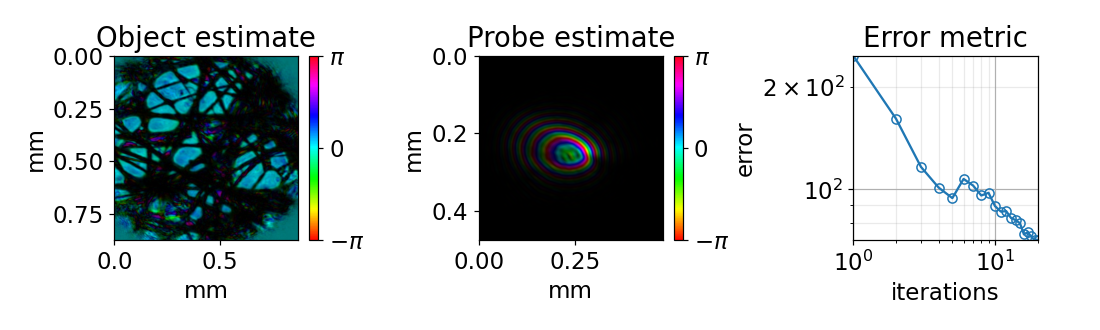

<IPython.core.display.Javascript object>


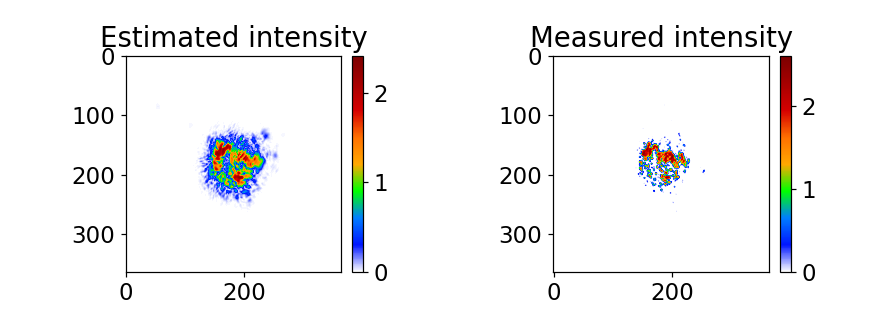

INFO:mqNewton:switch to gpu


Momentum Engines implemented: momentum, ADAM, NADAM
Momentum engine used: NADAM
                                                                                                                       
iteration: 0                                                                                                           
error: 245.9                                                                                                           
estimated linear overlap: 31.6 %                                                                                       
estimated area overlap: 66.4 %                                                                                         
                                                                                                                       
iteration: 1                                                                                                           
error: 161.1                                                                    

INFO:mqNewton:switch to cpu


In [8]:
# Run the reconstruction
# select reconstrution engine
engine_mqNewton = Engines.mqNewton(optimizable, exampleData, params, monitor)
engine_mqNewton.numIterations = 5
engine_mqNewton.betaProbe = 1
engine_mqNewton.betaObject = 1
engine_mqNewton.beta1 = 0.5
engine_mqNewton.beta2 = 0.5
engine_mqNewton.betaProbe_m = 1
engine_mqNewton.betaObject_m = 1
engine_mqNewton.momentum_method = 'NADAM'
engine_mqNewton.doReconstruction()

## Engine class
A specific engine can be imported (e.g. ePIE, mPIE etc.) and used on the optimizable class to "optimize" our initial estimates for the object/probe. In this example we use the quasi-Newton method to reconstruct the data, by passing the optimizable, exampleData and monitor objects to be used during the reconstruction


INFO:ePIE:Sucesfully created ePIE ePIE_engine
INFO:ePIE:Wavelength attribute: 4.4999998749517545e-07
INFO:ePIE:switch to gpu


                                                                                                                       
iteration: 0                                                                                                           
error: 107.4                                                                                                           
estimated linear overlap: 24.2 %                                                                                       
estimated area overlap: 71.4 %                                                                                         
                                                                                                                       
iteration: 1                                                                                                           
error: 102.7                                                                                                           
estimated linear overlap: 23.7 %        

INFO:ePIE:switch to cpu
INFO:mPIE:Sucesfully created mPIE mPIE_engine
INFO:mPIE:Wavelength attribute: 4.4999998749517545e-07


d:\du\workshop\fracpy\fracPy\Engines\BaseReconstructor.py:284: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn('fftshiftSwitch set to false, this may lead to reduced performance')
INFO:mPIE:switch to gpu


                                                                                                                       
iteration: 0                                                                                                           
error: 86.1                                                                                                            
estimated linear overlap: 22.7 %                                                                                       
estimated area overlap: 70.3 %                                                                                         
                                                                                                                       
iteration: 1                                                                                                           
error: 86.4                                                                                                            
estimated linear overlap: 21.3 %        

INFO:mPIE:switch to cpu
INFO:zPIE:Sucesfully created zPIE zPIE_engine
INFO:zPIE:Wavelength attribute: 4.4999998749517545e-07


d:\du\workshop\fracpy\fracPy\Engines\BaseReconstructor.py:284: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn('fftshiftSwitch set to false, this may lead to reduced performance')
INFO:zPIE:switch to gpu


zPIE: update z = 19.230 mm (dz = 0.1 um):   0%|                                                  | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


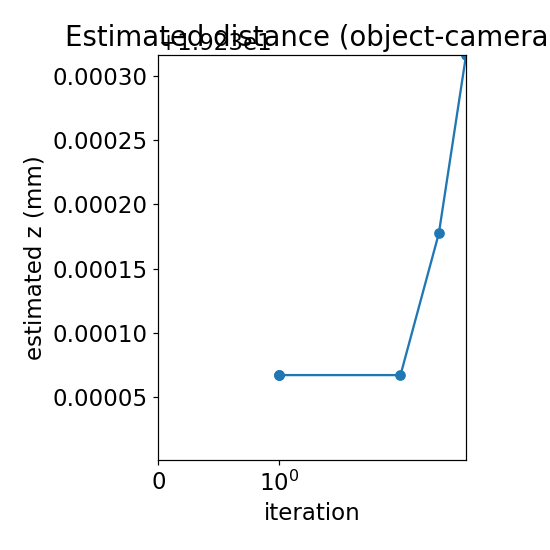

                                                                                                                       
iteration: 0                                                                                                           
error: 73.9                                                                                                            
estimated linear overlap: 23.5 %                                                                                       
estimated area overlap: 68.7 %                                                                                         
                                                                                                                       
iteration: 1                                                                                                           
error: 75.0                                                                                                            
estimated linear overlap: 23.1 %        

INFO:zPIE:switch to cpu


In [9]:
## switch engine if you need
# ePIE
engine_ePIE = Engines.ePIE(optimizable, exampleData, params,monitor)
engine_ePIE.numIterations = 5
engine_ePIE.betaProbe = 0.25
engine_ePIE.betaObject = 0.25
engine_ePIE.doReconstruction()

# mPIE
engine_mPIE = Engines.mPIE(optimizable, exampleData, params, monitor)
engine_mPIE.numIterations = 5
engine_mPIE.betaProbe = 0.25
engine_mPIE.betaObject = 0.25
engine_mPIE.doReconstruction()

# zPIE
engine_zPIE = Engines.zPIE(optimizable, exampleData, params, monitor)
engine_zPIE.numIterations = 5
engine_zPIE.betaProbe = 0.35
engine_zPIE.betaObject = 0.35
engine_zPIE.zPIEgradientStepSize = 100  # gradient step size for axial position correction (typical range [1, 100])
engine_zPIE.doReconstruction()

In [ ]:
# now save the data
# optimizable.saveResults('reconstruction.hdf5')